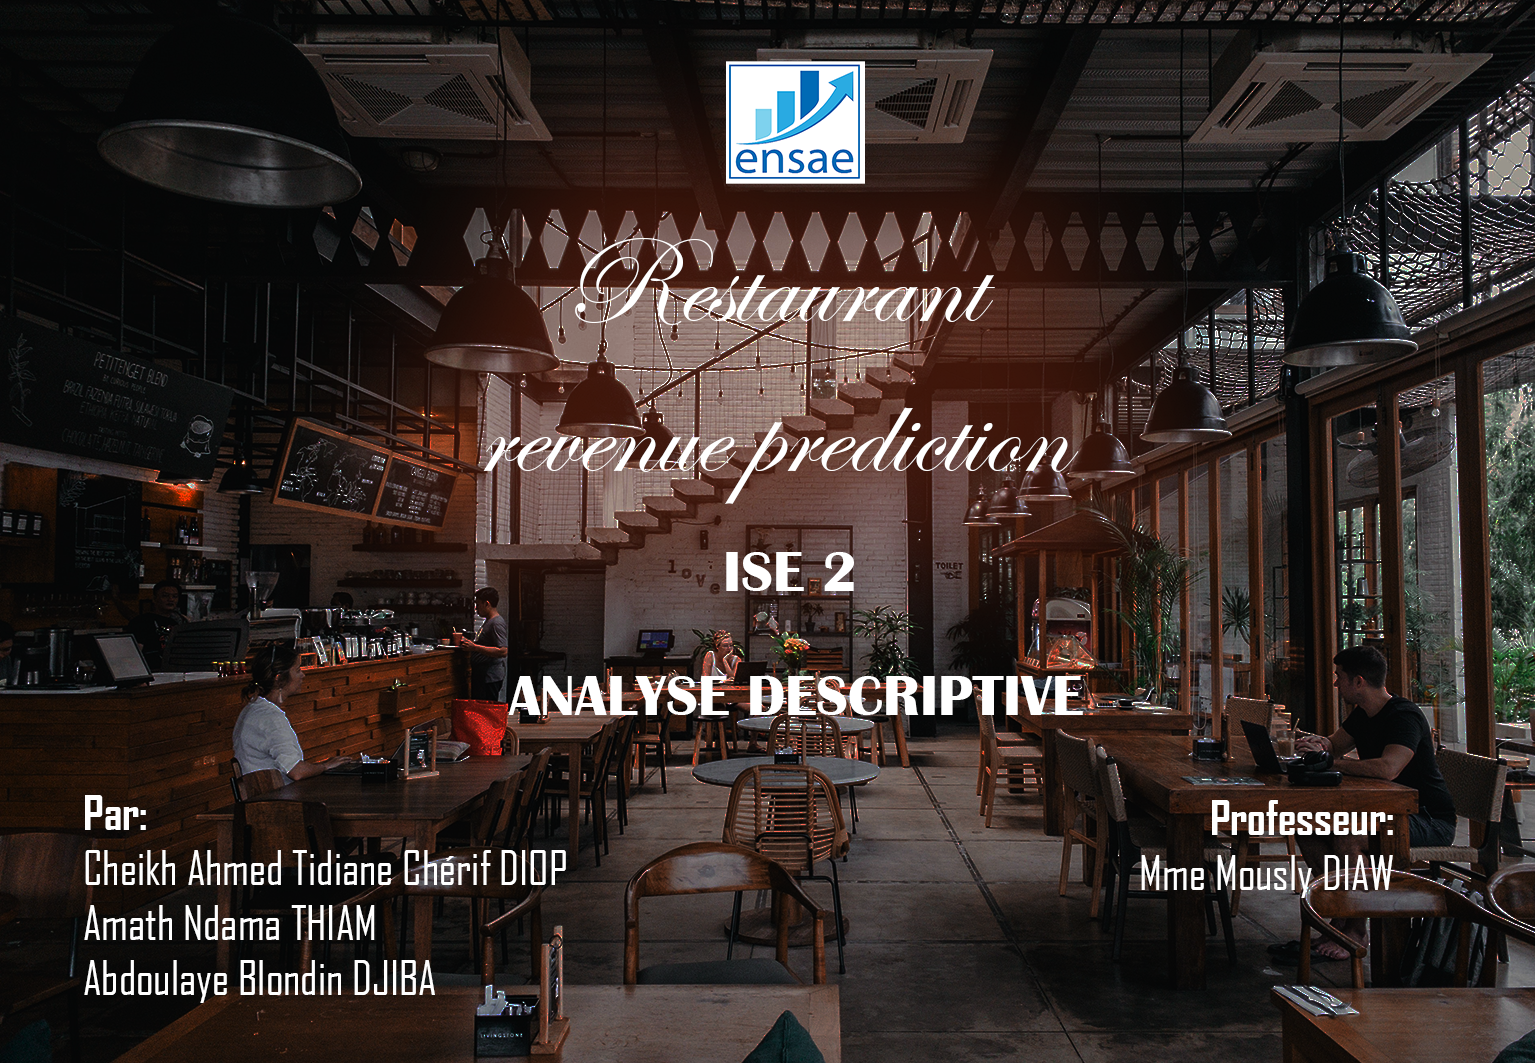

In [1]:
from IPython.display import Image
Image('image.png')

INTRODUCTION
------------------------

Dans le cadre de la soutenance concernant le cours d'Introduction au Machine Learning, nous avons le cas de la prévision des
revenus des restaurants. Ce projet concerne l'entreprise TFI qui investit dans le développement de grands sites de restaurants.

Ainsi, nous serons chargé de faire la prévision des revenus à partir des bases qui nous ont été données. 
Nous utiliserons ainsi une partie des connaissances du cours afin de pouvoir proposer le modéle qui propose de bons résultats.

Ce projet sera séparé en 2 notebook: le 1er et présent portera sur l'analyse descriptive et le second nommé Modeling portera sur 
le preprocessing et sur la construction du modéle


ANALYSE DESCRIPTIVE
-

La cellule suivante sera réservée à l'importation des différentes bibliothèques que nous utiliserons 

In [4]:
from datetime import datetime,time,timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import profile_report 
import plotly.express as px
import scipy as sp
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_california_housing, fetch_openml, load_boston, load_diabetes
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder,FunctionTransformer
import datetime
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from abc import ABC
from collections.abc  import Mapping
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_selector, make_column_transformer
%matplotlib inline

------------------------------------------
------------------------------------------
IMPORTATION LES BASES DE DONNEES

Ce projet est composé de 2 bases :
    la 1ère est la base d'entrainement sur laquelle nous allons créer notre modèle
    et la seconde est la base test sur laquelle nous devrons appliquer le modèle choisit et prédire les données

In [13]:
training=pd.read_csv('C:/Users/Hp/Desktop/study/machine learning/projet ml/train.csv')
X_test=pd.read_csv('test.csv')

Passons maintenant à une rapide description des variables de type objet

In [6]:
training.describe(include="O")

Open Date      City  City Group Type
count          137       137         137  137
unique         134        34           2    3
top     02/23/2010  İstanbul  Big Cities   FC
freq             2        50          78   76

Nous remarquons ainsi que la variable Open Date qui renseigne sur la date d'ouverture présente 134 
valeurs uniques sur 137 ce qui montre qu'il serait impertinent de l'utiliser de la sorte. Seulement 
la date d'ouverture peut quand même avoir un impact sur les revenus donc il serait pertinent de calculer
l'age de chaque restaurant au lieu d'éliminer la colonne en temps que tel

-
Commençons par la fonction qui transforme le format de la colonne Open Date en format Date

In [7]:
def formatdate(base):
    format="%m/%d/%Y"
    for i in range(base.shape[0]):
        base['Open Date'][i]=datetime.datetime.strptime(base['Open Date'][i], format)
    #base['Open Date'] = pd.to_datetime(base['Open Date'], format='%m/%d/%Y')
    #base['Open Date'] = datetime.datetime.strptime(base['Open Date'], '%m/%d/%Y')   
    return base

-
Passons ensuite à la fonction qui calcule l'âge et à l'application sur la base d''entrainement

In [8]:
def ageresto(base):
    for i in range(base.shape[0]):
        #base['Open Date'][i]=calculage(base['Open Date'][i])
        base['Open Date'][i]=(datetime.datetime.now() - base['Open Date'][i]).days // 365
    return base

In [14]:
formatdate(training)
ageresto(training)
training=training.drop('Id',1)
training

C:\Users\Hp\AppData\Local\Temp\ipykernel_6888\1910204945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Open Date'][i]=datetime.datetime.strptime(base['Open Date'][i], format)
C:\Users\Hp\AppData\Local\Temp\ipykernel_6888\2976253427.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  training=training.drop('Id',1)


Open Date        City  City Group Type  P1   P2   P3   P4  P5  P6  ...  \
0          23    İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2   2  ...   
1          14      Ankara  Big Cities   FC   4  5.0  4.0  4.0   1   2  ...   
2           9  Diyarbakır       Other   IL   2  4.0  2.0  5.0   2   3  ...   
3          10       Tokat       Other   IL   6  4.5  6.0  6.0   4   4  ...   
4          13   Gaziantep       Other   IL   3  4.0  3.0  4.0   2   2  ...   
..        ...         ...         ...  ...  ..  ...  ...  ...  ..  ..  ...   
132        14     Trabzon       Other   FC   2  3.0  3.0  5.0   4   2  ...   
133        16       İzmir  Big Cities   FC   4  5.0  4.0  4.0   2   3  ...   
134        16     Kayseri       Other   FC   3  4.0  4.0  4.0   2   3  ...   
135        12    İstanbul  Big Cities   FC   4  5.0  4.0  5.0   2   2  ...   
136        13    İstanbul  Big Cities   FC   4  5.0  3.0  5.0   2   2  ...   

     P29  P30  P31  P32  P33  P34  P35  P36  P37    revenue  
0    3.0    5    3    4    5    5    4    3    4  5653753.0  
1    3.0    0    0    0    0    0    0    0    0  6923131.0  
2    3.0    0    0    0    0    0    0    0    0  2055379.0  
3    7.5   25   12   10    6   18   12   12    6  2675511.0  
4    3.0    5    1    3    2    3    4    3    3  4316715.0  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...        ...  
132  3.0    0    0    0    0    0    0    0    0  5787594.0  
133  3.0    0    0    0    0    0    0    0    0  9262754.0  
134  3.0    0    0    0    0    0    0    0    0  2544857.0  
135  3.0    0    0    0    0    0    0    0    0  7217634.0  
136  3.0    0    0    0    0    0    0    0    0  6363241.0  

[137 rows x 42 columns]

In [15]:
categorical_features = training.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = training.select_dtypes(include="number").columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['Open Date', 'City', 'City Group', 'Type'], dtype='object')

Numerical features:
 Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue'],
      dtype='object')


-----------------
les corrélations avec le revenu

In [23]:
y=training['revenue']
X=training.drop('revenue',1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_6888\3678201789.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=training.drop('revenue',1)


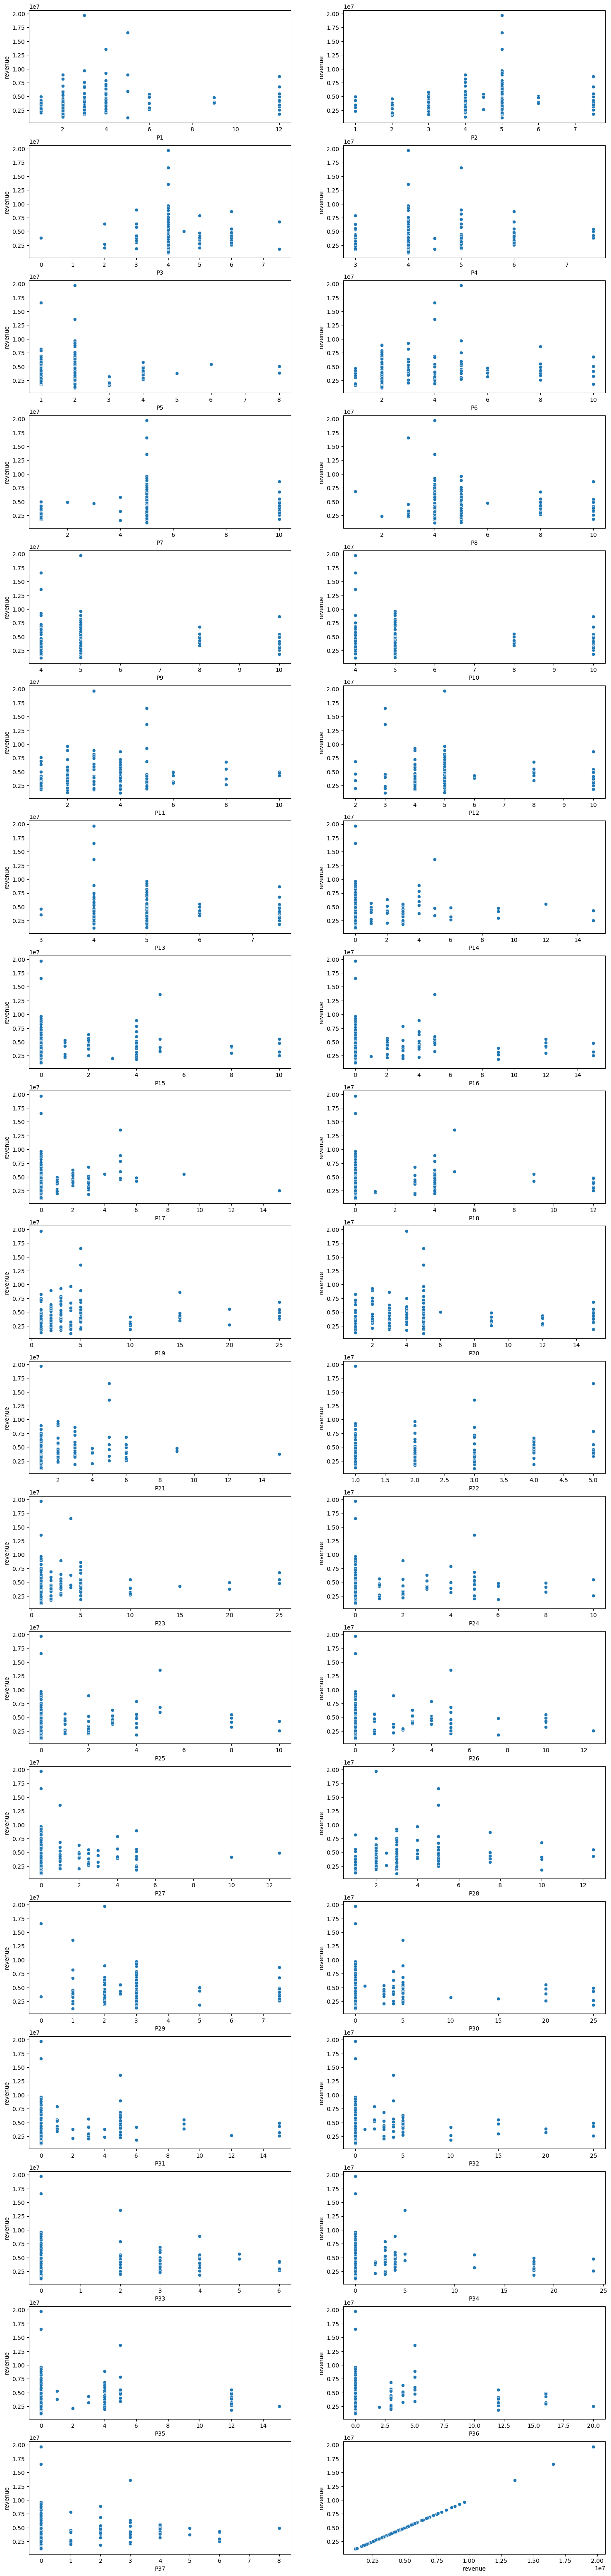

In [25]:
nrows = sum(divmod(len(numerical_features), 2))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(18, 80))
axes = axes.ravel()

for i, col_name in enumerate(numerical_features):
    sns.scatterplot(x=col_name, y=y, data=training, ax=axes[i])

-------------------------------------------------
le graphique ci dessous était une tentative pour voir les 
éventuelles corrélations entre les variables indépendantes
mais vu le nombre de variables il sera compliqué de 
l'interpréter

In [26]:
sns.pairplot(X, corner=True, diag_kind="kde")

------------------------------------
Là il serait important de voir si les revenus de la base d'entrainement suivent ou s'approchent d'une loi
normale. AInsi nous allons visualiser la variable revenue avec et sans l'application du log

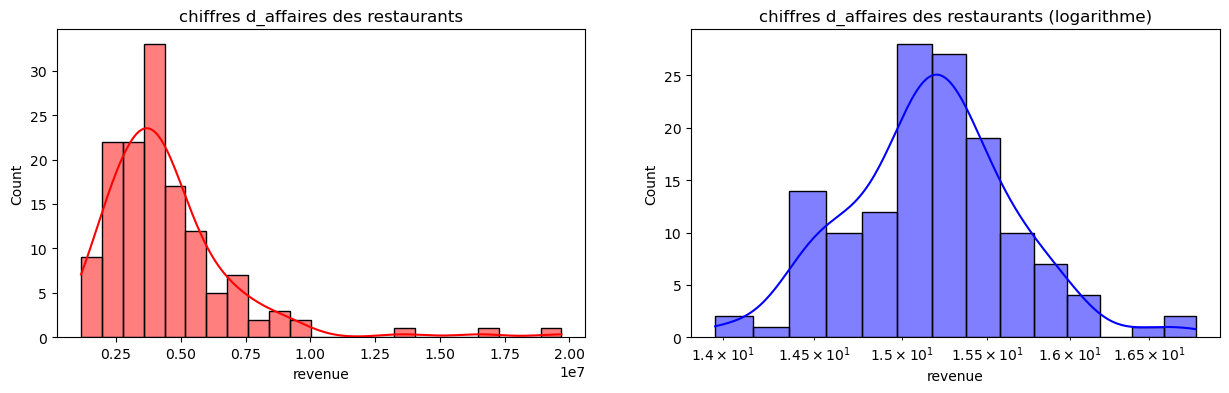

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(y, color='r', kde=True, ax=axes[0])
axes[0].set_title('chiffres d_affaires des restaurants')

log_y = np.log(y)
sns.histplot(log_y, color='b', kde=True, ax=axes[1])
axes[1].set_title('chiffres d_affaires des restaurants (logarithme)')
axes[1].set_xscale('log')


Nous voyons ainsi qu'avec l'application du log les revenus s'approchent
beaucoup plus d'une loi normale. AInsi dans la modélisation nous utiliserons
le logarithme des revenus

-----------------------
Nous allons maintenant construire des box plot pour les variables 
de type objet afin de voir la présence ou non de valeurs abbérantes

In [74]:
categorical_features = X.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

Categorical features:
 Index(['Open Date', 'City', 'City Group', 'Type'], dtype='object')



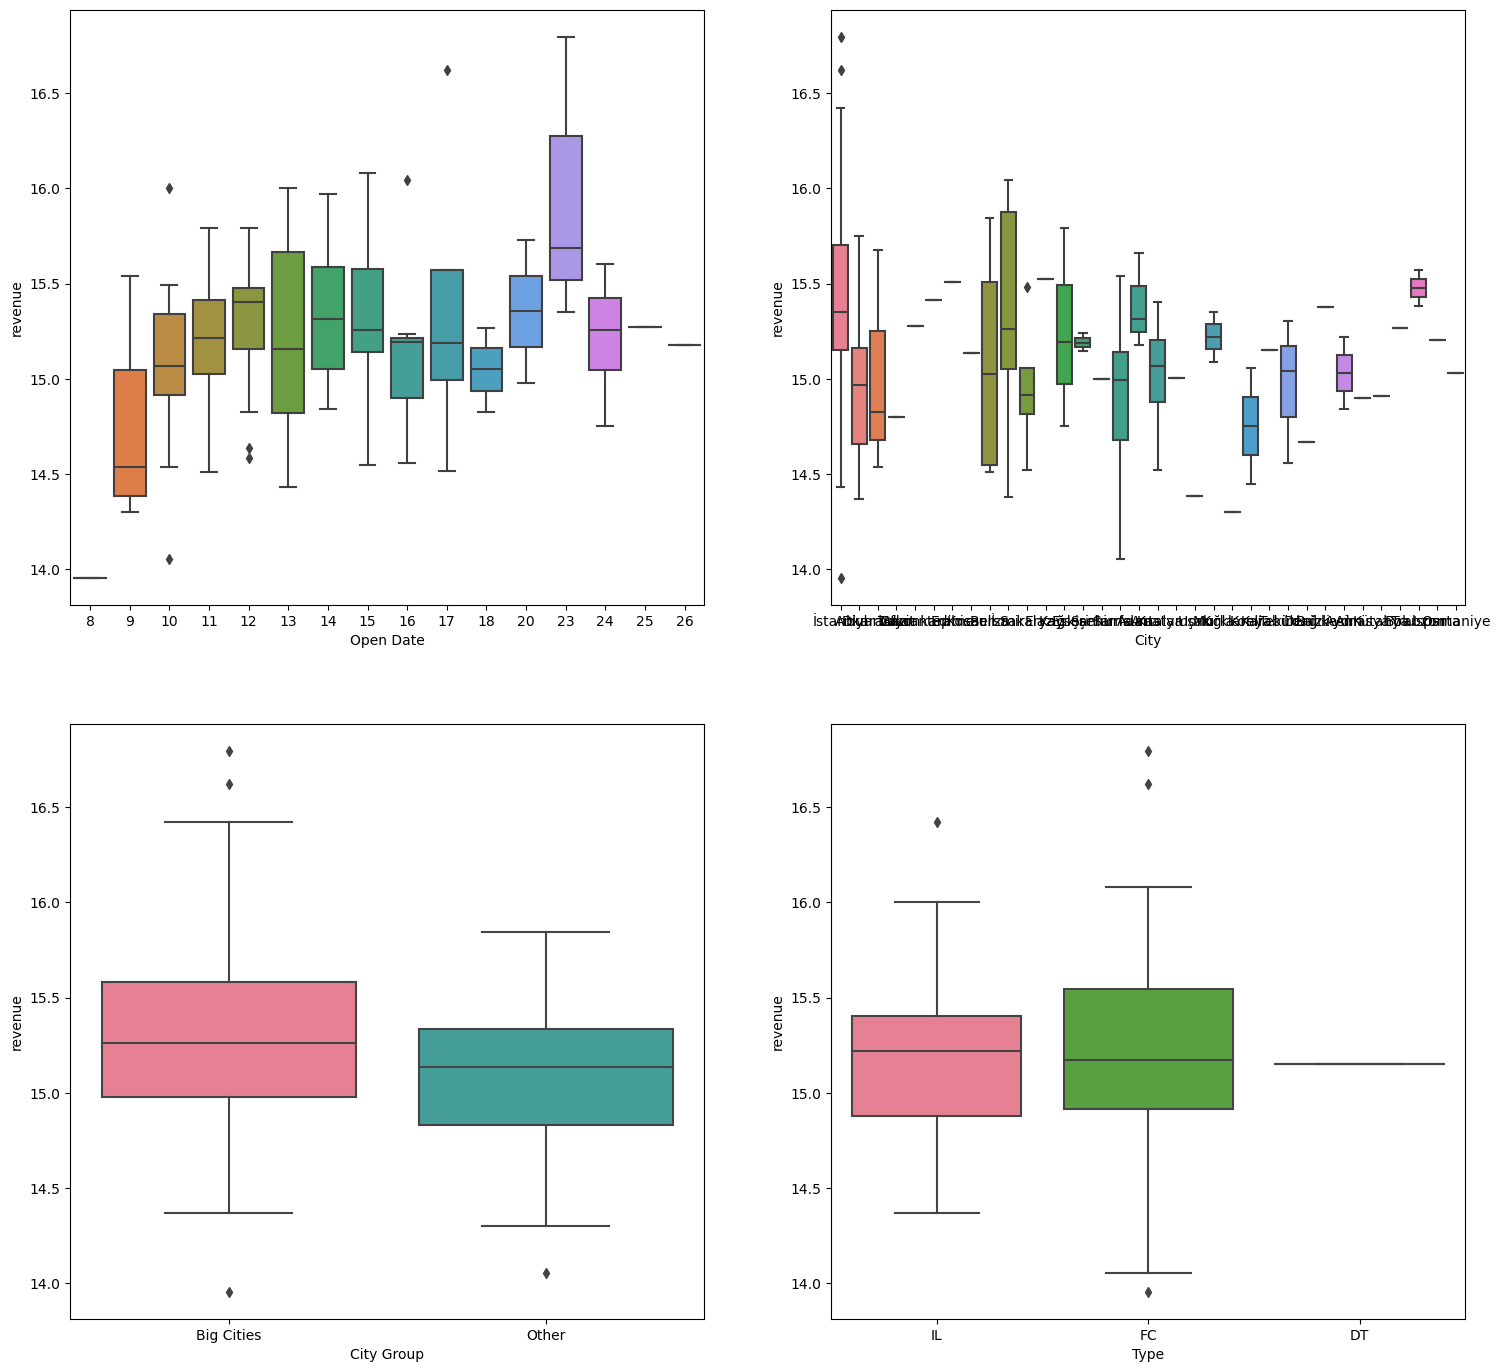

In [73]:

ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 17))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.boxplot(x=col_name, y=log_y, data=X, palette='husl', ax=ax)

*Notons que Open Date a été considéré comme Objet car elle n'a pas
encore été reconverti après le calcul de l'âge*